### About
- This notebook is an implementation of the following papers.
    - [Depth Map Prediction from a Single Image using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf) by Eigen et al., NIPS 2014
- Dataset
    - [NYU Depth Dataset V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Device configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Hyper parameters

In [108]:
num_epochs = 20 # not specified in paper
batch_size = 32

### Dataset loader

### Network definition

In [129]:
class GlobalCoarseNet(nn.Module):
    
    def __init__(self):
        super(GlobalCoarseNet, self).__init__()
        
        self.coarse1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        self.coarse2 = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        
        self.coarse3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse4 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse5 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=2), 
                                     nn.ReLU())
        
        self.coarse6 = nn.Sequential(nn.Linear(in_features=256 * 8 * 6, out_features=4096), 
                                     nn.ReLU(), nn.Dropout(0.5))
        
        self.coarse7 = nn.Linear(in_features=4096, out_features=74 * 55)
    
    def forward(self, x):
        x = self.coarse1(x)
        x = self.coarse2(x)
        x = self.coarse3(x)
        x = self.coarse4(x)
        x = self.coarse5(x)
        x = x.reshape(batch_size, -1)
        x = self.coarse6(x)
        x = self.coarse7(x)
        x = x.reshape(batch_size, 74, 55)
        return x

class LocalFineNet(nn.Module):
    
    def __init__(self):
        super(LocalFineNet, self).__init__()
        
        self.fine1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=63, kernel_size=9, stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        
        self.fine2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2), 
                                   nn.ReLU())
        
        self.fine3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
    
    def forward(self, x, global_output_batch):
        x = self.fine1(x)
        x = torch.cat((x, global_output_batch), dim=1)
        x = self.fine2(x)
        x = self.fine3(x)
        
        return x

# initialize
global_model = GlobalCoarseNet().to(device)
local_model = LocalFineNet().to(device)

### Loss and optimizer
- Reference
    - [Per-parameter options](https://pytorch.org/docs/stable/optim.html)

In [154]:
class ScaleInvariantLoss(nn.Module):
    def __init__(self):
        super(ScaleInvariantLoss, self).__init__()

    def forward(self, pred, target):
        
        dist = pred - target
        
        # the lambda parameter is set to 0.5
        loss = torch.mean(dist ** 2) - 0.5 / ((torch.numel(dist)) ** 2) * (torch.sum(dist) ** 2) 
        
        return loss

# loss
global_criterion = ScaleInvariantLoss()
local_criterion = ScaleInvariantLoss()

# optimizer
r=100
global_optimizer = torch.optim.SGD([{'params': global_model.coarse6.parameters(), 'lr': 0.1*r},
                                    {'params': global_model.coarse7.parameters(), 'lr': 0.1*r}], 
                                   lr=0.001*r, momentum=0.9)

local_optimizer = torch.optim.SGD([{'params': local_model.fine2.parameters(), 'lr': 0.01*r}], 
                                  lr=0.001*r, momentum=0.9)

### Plot gradient flow
- Reference
    - [plot function](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7)
    - [get gradient of each layer](https://discuss.pytorch.org/t/how-to-calculate-gradient-for-each-layer/1595/4)

In [140]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

### Train the global coarse model

coarse1.0.bias :  tensor(3.0631e-06)
coarse2.0.bias :  tensor(2.4710e-06)
coarse3.0.bias :  tensor(3.2328e-06)
coarse4.0.bias :  tensor(7.5263e-06)
coarse5.0.bias :  tensor(2.1005e-05)
coarse6.0.bias :  tensor(2.6425e-06)
coarse7.bias :  tensor(6.9310e-05)
loss at 1 is 0.9982923865318298


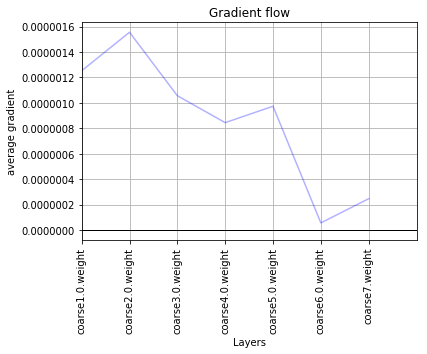

In [161]:
a = torch.randn(batch_size, 3, 304, 228)
a = a.to(device)

target = torch.randn(batch_size, 74, 55)
target = target.to(device)

losses = []
for i in range(1):
    # forward pass
    output = global_model(a)
    loss = global_criterion(output, target)
    losses.append(loss.item())
    
    # backward pass
    global_model.zero_grad()
    loss.backward()
    plot_grad_flow(global_model.named_parameters())
    global_optimizer.step()
    
    print('loss at {} is {}'.format(i + 1, loss))

#plt.plot(losses)

### Train the local fine model

loss at 1 is 1.003607988357544
loss at 2 is 1.003606915473938
loss at 3 is 1.0036042928695679
loss at 4 is 1.0036044120788574
loss at 5 is 1.003603458404541
loss at 6 is 1.0036035776138306
loss at 7 is 1.0036031007766724
loss at 8 is 1.003603219985962
loss at 9 is 1.0036033391952515
loss at 10 is 1.0036033391952515


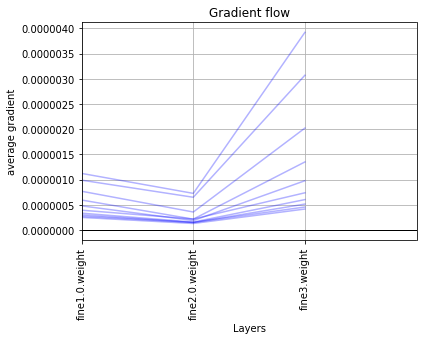

In [157]:
global_model.eval()
with torch.no_grad():
    global_output = global_model(a).unsqueeze(1)

losses = []
for i in range(10):
    
    # forward pass
    output = local_model(a, global_output)
    loss = local_criterion(output, target)
    losses.append(loss.item())
    
    # backward pass
    local_model.zero_grad()
    loss.backward()
    plot_grad_flow(local_model.named_parameters())
    local_optimizer.step()
    
    print('loss at {} is {}'.format(i + 1, loss))